# Creating the model
In the last notebook, we've created a generotor class to load and process our data batch by batch to save our ram from exploding.  
I hope that you've saved this class in a file, because I did and I'll be using it now.  
But first let's create the model

## Model architecture
The model I'll be building is based on the LeNet architecture.  
[Go read the paper ... __NOW__](http://cs231n.stanford.edu/reports/2016/pdfs/010_Report.pdf)  
Having read this paper I went with the following architecture, You can choose whatever you want.  
Just note that I've designed the input shape and depth of the architecture such that the last conv layer has the same size of the first dense layer. that's not necessary but if the last conv layer has too many neurons the model is gonna get big and won't fit in memory throwing an OOM error

In [1]:
## let's first load some stuff from keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import os
# The class we've created in the previous notebook
from datagenerator import FacialKeyPointsDataset

In [2]:
# Now let's create the actual model
# No one says that you should go with the same architecture,
# but this bad boy works and it works well. feel free to post an issue if you find a better architecture.
model = Sequential([
    Conv2D(16, 3, input_shape=[194, 194, 1], activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(32, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(64, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(128, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(256, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Conv2D(512, 3, activation="relu"),
    BatchNormalization(),
    MaxPool2D(),

    Flatten(),

    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dense(512, activation="relu"),
    BatchNormalization(),

    Dense(136)
])

In [3]:
# it's always good to look at the model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 192, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        1

## Get the data
Ok, We've imported the FacialKeyPointsDataset Class but never created and instance.  
let's do that now

In [4]:
# If the parameters given to the initializer doesn't look familiar
# I'd suggest going back to notebook 1.1
data_generator = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             output_size=(194, 194),
                                             batch_size=10,
                                             normalization="vector")

In [5]:
# Compiling the model
# The loss function used here is inspired by udacity's computer vision nanodegree
# Actually the whole project is

tf.keras.backend.clear_session()
model.compile(
    loss=tf.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=['accuracy']
)

## Train the model
The `fit` method on a model accepts a generator now.  
No need to use the old `fit_generator` method.  
I'd recommend that you use early stopping, I don't intend to train for many epochs in this demo. **But you should**

In [6]:
earlyStopping = EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
history = model.fit(data_generator, epochs=3, callbacks=[earlyStopping])

Train for 346 steps
Epoch 1/3
346/346 [==============================] - 308s 890ms/step - loss: 0.0948 - accuracy: 0.0179
Epoch 2/3
346/346 [==============================] - 229s 662ms/step - loss: 0.0676 - accuracy: 0.0275
Epoch 3/3
346/346 [==============================] - 228s 660ms/step - loss: 0.0549 - accuracy: 0.0419


## Yay! Let's save the model
This model is going to suck.  
Why? because it's not trained enough. this is just a demo.  
Use colab if you don't have a strong gpu and train it more then save the model

In [7]:
# saving the architecture of the model
model_json = model.to_json()
with open("models/dummy_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("models/dummy_model.h5")


## Loading and using the model
I am going to use a model that I've trained previously

In [8]:
# load json and create model
json_file = open('models/model_vector_batchnorm_194.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("models/model_vector_batchnorm_194.h5")

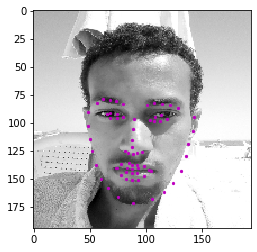

In [9]:
## Now let's try it
# read the image
img = mpimg.imread("data/test2.jpg")
# preprocess the image using the data generator
img = data_generator.preprocess_test(img)
# get the prediction, here we reshape the image to make a batch of one image
keypts = model.predict(img.reshape(1, 194, 194, 1)).reshape(-1, 1)
# undo keypoint normalization ... see those attribures? remember them?
# if you don't, refer to the notebook 1.1
keypts = keypts * data_generator.std + data_generator.mean
# create point ordered pairs
keypts = keypts.reshape(-1, 2)

plt.imshow(img.reshape(194, 194), cmap="gray")
plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=20, color="m")
plt.show()

## There you go
